In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pickle

#In order to allow to print all the 111 columns
pd.set_option('display.max_columns', 120)
import sys
#sys.path.insert(0,"/home/reda/py-kmeans/")

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import r2_score , log_loss, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RandomizedLasso,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from pylab import barh
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE

from scipy.cluster.hierarchy import dendrogram, linkage,cut_tree
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [2]:
sigma = pd.read_hdf("./data/train.h5")

#### Preprocessing

In [3]:
sigma_medians = sigma.median(axis=0)
sigma.fillna(sigma_medians,axis=0,inplace=True)

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,-0.179404,0.033375,-0.072108,0.249187,0.024401,-0.127942,0.014806,1.412742,-0.029575,1.265246,-0.055747,1.592256,-0.285275,-0.212888,0.404180,0.116903,0.197590,-0.197455,-0.195023,-0.059886,-0.021199,-0.013555,-0.236371,-0.253357,0.575562,0.283947,-0.006208,0.616351,-0.034578,0.732652,-0.002432,-0.092508,-0.072185,0.447296,-0.194318,0.264373,0.018763,-0.005227,-0.145278,-0.108547,0.148189,-0.226942,0.262864,-0.252933,-0.113265,0.180559,-0.033812,0.042951,-0.068031,0.208402,-0.082743,1.061059,1.120801,-0.228200,-0.119987,-0.131929,-0.145985,-0.155989,-0.000719,0.037680,-2.293301e-09,-0.000483,-2.000000e+00,-0.000330,0.000034,-2.000000e+00,-0.273957,-0.000000e+00,-2.000000e+00,-2.000000e+00,-5.771427e-05,0.001652,-2.000000e+00,0.000000e+00,-2.000000e+00,-0.000000e+00,0.652981,0.000000,-0.142453,0.0,0.000190,0.000376,1.427469,0.000239,-2.000000e+00,0.000000,-0.000382,-4.730027e-14,0.000374,0.0,0.937880,0.775208,-3.951567e-12,-1.418487e-13,-1.591224e-16,-0.414776,0.000098,0.000000e+00,-2.000000e+00,0.000011,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,0.216281,0.096750,0.082042,-0.224383,-0.085529,0.024763,-0.062337,-0.202247,1.746692,-0.187505,-0.034664,-0.135177,0.305562,0.027595,-0.208746,0.118520,-0.123511,0.113818,-0.017468,-0.115837,0.028282,0.076565,-0.217346,0.100054,0.358808,0.057505,0.025719,-0.141339,2.293476,0.024945,0.388208,-0.240927,-0.126232,-0.131619,0.232268,-0.001455,-0.489863,0.017317,0.027321,0.334183,0.113513,0.111536,-0.179379,0.221287,-0.091886,0.005917,0.107982,0.548687,-0.160079,-0.281368,0.063933,-0.235643,-0.205083,-0.194349,-0.365186,0.041928,-0.044907,-0.039079,-0.075000,-0.280418,-2.293301e-09,-0.000483,-2.000000e+00,-0.000330,0.000034,-2.000000e+00,-0.159432,-0.000000e+00,0.000000e+00,-2.000000e+00,-5.771427e-05,0.004317,0.000000e+00,0.000000e+00,-2.000000e+00,-0.000000e+00,-0.399520,0.000000,-0.309356,-0.5,0.000190,0.000376,0.154613,0.000239,0.000000e+00,0.000000,-0.000382,-4.730027e-14,0.000374,0.5,0.232154,0.025590,-3.951567e-12,-1.418487e-13,-1.591224e-16,-0.273607,0.000098,0.000000e+00,-2.000000e+00,0.000011,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,-0.040183,0.033375,-0.051418,-0.258330,-0.122140,-0.121041,-0.058287,-0.899515,-0.022131,-0.079002,-0.031116,-0.100603,-0.341474,-0.007522,0.077977,-0.149581,0.036946,0.166182,-0.01746

In [67]:
def print_info(sigma):
    print("data dimension :{}".format(sigma.shape))
    print("unique ids: {}".format(len(sigma["id"].unique())))
    print("unique Timestamps: {}".format(len(sigma["timestamp"].unique())))

In [4]:
sigma_train = sigma[sigma["timestamp"].isin(sigma["timestamp"].unique()[:913])]
sigma_test = sigma[sigma["timestamp"].isin(sigma["timestamp"].unique()[913:])]

In [75]:
print_info(sigma_train)

data dimension :(813071, 111)
unique ids: 1096
unique Timestamps: 913


In [76]:
print_info(sigma_test)

data dimension :(897685, 111)
unique ids: 1297
unique Timestamps: 900


#### Clipping

/home/reda/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


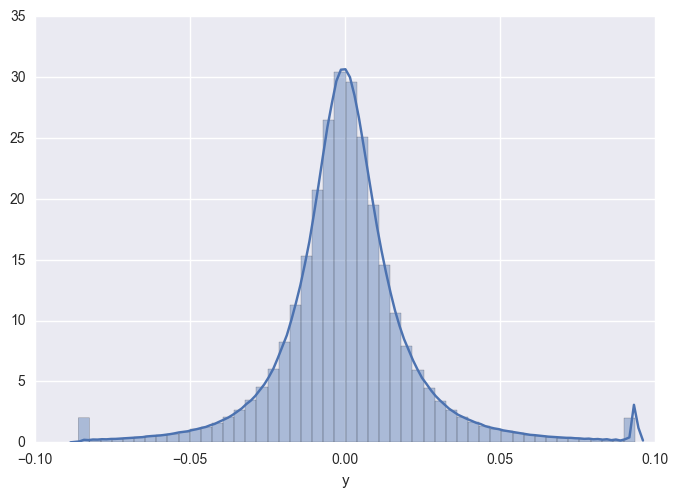

In [25]:
sns.distplot(sigma.y)

In [30]:
hist= np.hstack(sigma.y)

(array([ 11291.,    100.,    100.,     99.,    104.,    112.,    119.,
           108.,    100.,    108.,    111.,    102.,    109.,    121.,
           118.,    124.,    131.,    121.,    130.,    119.,    147.,
           128.,    146.,    131.,    125.,    135.,    137.,    134.,
           147.,    142.,    144.,    134.,    146.,    150.,    153.,
           158.,    162.,    144.,    151.,    187.,    168.,    159.,
           146.,    166.,    159.,    186.,    207.,    176.,    206.,
           200.,    178.,    202.,    185.,    201.,    198.,    216.,
           214.,    241.,    230.,    224.,    217.,    209.,    197.,
           220.,    231.,    241.,    241.,    260.,    283.,    225.,
           278.,    292.,    276.,    273.,    298.,    284.,    295.,
           302.,    274.,    298.,    304.,    282.,    314.,    298.,
           323.,    347.,    331.,    323.,    339.,    344.,    349.,
           357.,    370.,    357.,    386.,    399.,    378.,    406.,
      

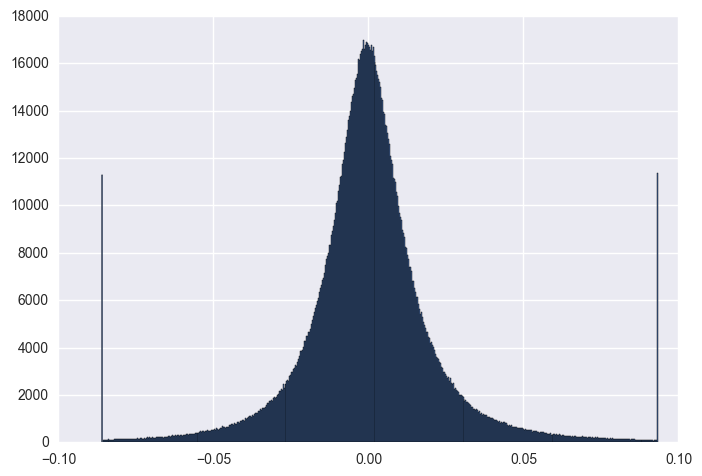

In [31]:
plt.hist(hist,bins='auto')

In [22]:
print("max train value: {}".format(sigma.y.max()) )
print("min train value: {}".format(sigma.y.min()))

max train value: 0.09349780529737473
min train value: -0.08609412610530853


In [36]:
y_high_cut=0.0931788143
y_low_cut=-0.0857751351
def clip_df(sigma):
    y_high_cut=0.0931788143
    y_low_cut=-0.0857751351
    y_above_cut= sigma.y>y_high_cut
    y_below_cut=sigma.y<y_low_cut
    y_within_cut= (~y_above_cut & ~y_below_cut)
    return y_above_cut, y_below_cut, y_within_cut

In [132]:
_,_,y_within_cut=clip_df(sigma)

In [133]:
y_within_cut.value_counts()

True     1688086
False      22670
Name: y, dtype: int64

#### TRain ans test sets

In [39]:
sigma_train.drop(["id","timestamp"],axis=1,inplace=True)
sigma_test.drop(["id","timestamp"],axis=1,inplace=True)

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
_,_,y_within_cut = clip_df(sigma_train)

X=sigma_train.loc[y_within_cut,~sigma_train.columns.isin(["y"])].values
y=sigma_train.loc[y_within_cut,"y"].values

X_test=sigma_test.loc[:,~sigma_test.columns.isin(["y"])].values
y_test=sigma_test.loc[:,"y"].values

#### Linear models

In [41]:
predictors=["technical_13","technical_20","technical_30","technical_11","technical_19"]
variables=["technical_13","technical_20","technical_30","technical_11","technical_19","y"]
sigma_train=sigma_train.loc[:,variables]
sigma_test=sigma_test.loc[:,variables]

In [42]:
_,_,y_within_cut = clip_df(sigma_train)

X=sigma_train.loc[y_within_cut,~sigma_train.columns.isin(["y"])].values
y=sigma_train.loc[y_within_cut,"y"].values

X_test=sigma_test.loc[:,~sigma_test.columns.isin(["y"])].values
y_test=sigma_test.loc[:,"y"].values

In [48]:
lm = LinearRegression(normalize=True).fit(X,y)

In [49]:
lm.predict(X_test)

array([ 0.00033659,  0.00042182,  0.00032602, ...,  0.00023604,
       -0.00022885,  0.0002344 ], dtype=float32)

In [25]:
r2_score(y_test,lm.predict(X_test).clip(y_low_cut, y_high_cut))

0.0003784123256713734

In [26]:
r2_score(y_test,lm.predict(X_test))

0.0003784123256713734

In [99]:
columns = sigma_train.columns

In [135]:
ridge = Ridge(alpha=1,max_iter=10000,normalize=True).fit(X,y)

In [136]:
ridge.coef_

array([ -1.48331279e-08,  -2.50048584e-19,   1.89564060e-07,
         1.68982764e-07,   4.82340122e-09,   3.63955452e-05,
         7.33106322e-17,   4.30529459e-06,  -1.18978618e-05,
        -5.62816046e-07,   7.08132615e-06,   3.58397004e-10,
         1.66177826e-04,   8.74936199e-06,   5.33637992e-06,
         6.18665212e-06,   1.29556935e-07,   1.34114465e-04,
        -2.69211499e-08,   5.33404959e-06,   3.44797894e-06,
         1.53981077e-21,   3.72509150e-06,   3.54971418e-07,
         6.83649163e-09,  -2.85033205e-05,   1.82171017e-06,
        -9.07320831e-10,   1.12841153e-05,   2.94119222e-06,
         9.00587360e-11,   4.81912550e-08,   2.54710687e-05,
        -1.58829264e-05,  -3.08847752e-05,   7.68038006e-05,
         2.64712215e-07,  -9.82579296e-11,   4.27102678e-07,
        -4.19364523e-06,   3.92013042e-10,   1.21272244e-05,
        -2.42274606e-06,   1.14525629e-06,   1.61079099e-05,
         5.01293749e-12,  -1.88835211e-10,  -6.52071734e-06,
         4.95202740e-06,

In [95]:
np.arange(len(ridge.coef_))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107])

<Container object of 108 artists>

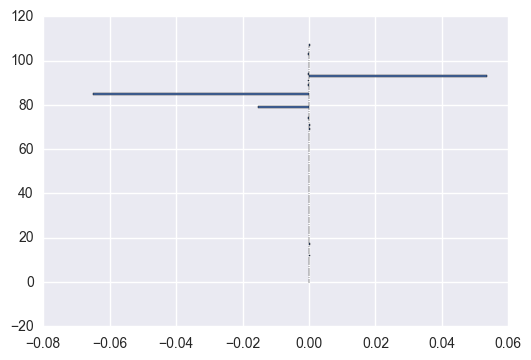

In [140]:
barh(np.arange(len(ridge.coef_)),ridge.coef_,align='center')

In [141]:
ridge.score(X_test,y_test)

-0.018095378149693975

indexes = np.absolute(ridge.coef_)>np.sort(np.absolute(ridge.coef_))[::-1][3]
np.where(indexes == True)

In [144]:
X=X[:,indexes]

In [145]:
X.shape

(803548, 3)

In [157]:
print("selected columns : %s,%s,%s"%(columns[79],columns[85],columns[93]) )

selected columns : technical_13,technical_20,technical_30


#### Averaging of linear models

In [14]:
predictors_1=["technical_30","technical_20","fundamental_11","technical_19"]
predictors_2=["technical_13","technical_36","fundamental_35"]
predictors_3=list(filter(lambda c: c not in predictors_1 + predictors_2, sigma.columns))
predictors_4=['derived_0', 'derived_1', 'derived_3', 'fundamental_0',
               'fundamental_7', 'fundamental_10', 'fundamental_12',
               'fundamental_17', 'fundamental_18', 'fundamental_19',
               'fundamental_20', 'fundamental_21', 'fundamental_25',
               'fundamental_32', 'fundamental_33', 'fundamental_36',
               'fundamental_41', 'fundamental_42', 'fundamental_45',
               'fundamental_48', 'fundamental_53', 'fundamental_59',
               'fundamental_62', 'technical_0', 'technical_2', 'technical_3',
               'technical_6', 'technical_7', 'technical_9', 'technical_11',
               'technical_12', 'technical_14', 'technical_16', 'technical_17',
               'technical_18', 'technical_21', 'technical_22', 'technical_24',
               'technical_27', 'technical_29', 'technical_32', 'technical_33',
               'technical_34', 'technical_35', 'technical_37', 'technical_38',
               'technical_39', 'technical_40', 'technical_41', 'technical_42',
               'technical_43']

###### Linear regresssion on predictors_1

In [7]:
X=sigma_train.loc[:,predictors_1].values
y=sigma_train.loc[:,"y"].values

X_test=sigma_test.loc[:,predictors_1].values
y_test=sigma_test.loc[:,"y"].values

In [14]:
linear=LinearRegression().fit(X,y)

In [15]:
linear.score(X_test,y_test)

0.00037543136035489422

###### Ridge on predictors_2

In [75]:
X=sigma_train.loc[:,predictors_2].values
y=sigma_train.loc[:,"y"].values

X_test=sigma_test.loc[:,predictors_2].values
y_test=sigma_test.loc[:,"y"].values

In [85]:
ridge=Ridge(alpha=15).fit(X,y)

In [22]:
ridge.score(X_test,y_test)

2.8544915869122001e-05

In [86]:
ridge.score(X_test,y_test)

2.8874106558607338e-05

###### Lasso on predictors_3

In [23]:
X=sigma_train.loc[:,predictors_3].values
y=sigma_train.loc[:,"y"].values

X_test=sigma_test.loc[:,predictors_3].values
y_test=sigma_test.loc[:,"y"].values

In [30]:
lasso=Lasso(alpha=5).fit(X,y)

/home/reda/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [31]:
lasso.score(X_test,y_test)

-9.2424239951593989e-05

###### Lasso on other predictors

In [4]:
sigma_train=sigma_train.loc[:,~sigma_train.columns.isin(["id","timestamp"])]
sigma_test=sigma_test.loc[:,~sigma_test.columns.isin(["id","timestamp"])]

In [5]:
sigma_null = sigma_train.isnull().sum(axis=0)/len(sigma_train)

In [6]:
predictors_4=sigma_null[sigma_null<0.1].index.values

In [7]:
len(predictors_4)

57

In [11]:
predictors_4=pd.Series(predictors_4)[~pd.Series(predictors_4).isin(pd.Series(predictors_1+predictors_2))].values

In [10]:
sigma_medians = sigma_train.median(axis=0)
sigma_train.fillna(sigma_medians,axis=0,inplace=True)
sigma_test.fillna(sigma_medians,axis=0,inplace=True)

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
813071,0.215332,0.095199,0.001385,-0.026588,0.385806,-0.265647,0.555014,0.232489,-0.106695,-0.124923,0.264698,-0.139213,0.053716,-0.049837,0.012222,0.159682,-0.027207,0.208751,0.012680,0.212359,-0.234602,0.029501,0.197127,0.038501,0.133614,-0.067597,0.075488,-0.041754,-0.055573,0.382194,0.080105,0.642717,0.154875,-0.045064,0.075447,0.067072,-0.014569,-0.161013,0.005714,0.086485,0.032636,0.063862,0.386799,0.064190,0.275324,-0.095816,-0.076432,-0.094237,-0.010000,-0.159504,0.146307,-0.099930,-0.007354,0.007541,0.012119,-0.008887,0.299012,0.159930,0.040789,0.156106,0.208559,-0.129233,0.230551,-0.112381,-0.130421,-0.098431,-3.737341e-01,0.071047,-1.013312e-10,-0.053182,-1.249991e-01,-0.035768,-0.022608,-1.249799e-01,-1.775032e-07,-9.654508e-11,0.000000e+00,-1.249991e-01,-4.500361e-12,0.000159,-1.993199e+00,0.000000e+00,-1.246980e-01,-9.654508e-11,-0.243035,0.000000,0.236270,0.0,0.122774,-0.007963,-0.357603,0.032526,0.000000e+00,0.000000,-0.018948,-9.654508e-11,-0.059384,0.0,-0.070462,-0.197750,-1.010454e-10,-1.010454e-10,-9.654508e-11,-0.053740,0.003141,9.590210e-06,-1.999980e+00,-0.064976,-0.007611
813072,0.138654,1.938654,0.756137,-0.236643,0.175601,-0.324815,-0.110032,-0.508540,-0.018637,0.044959,-0.876012,0.340374,-0.141210,-0.343715,0.005225,-0.633851,0.072941,0.006462,-0.042639,0.140944,0.174524,-0.033396,0.052267,-0.184645,-0.075130,-0.076694,0.092931,-0.088388,0.071066,-0.156372,-0.078922,-0.300635,-0.031583,-0.292529,0.593951,-0.019658,0.140589,-0.091104,0.065651,2.396694,0.675694,-0.109365,-0.846510,0.049577,-0.194009,-0.417799,-0.224574,0.151009,-0.190571,0.060537,-0.109125,-0.114173,0.865171,-0.028072,-0.233417,-0.043650,-0.067843,0.018347,-0.130578,-0.388422,-0.292282,-0.169001,-0.045870,0.217836,0.490406,-0.099983,-1.656985e-34,0.071047,-3.400588e-03,0.071582,-1.875000e+00,-0.002498,0.046713,-3.330669e-16,6.028727e-02,-6.250000e-02,-6.801176e-03,-1.875000e+00,-3.400588e-03,0.000000,-1.993199e+00,-3.400588e-03,-1.993199e+00,0.000000e+00,0.301693,0.000000,-0.263955,-0.5,-0.134228,0.081908,0.002521,0.021396,0.000000e+00,0.000465,0.034790,-3.400588e-03,-0.042211,-0.5,-0.012731,-0.171868,-3.400588e-03,-3.400588e-03,-3.400588e-03,-0.021048,-0.121192,-3.400588e-03,-3.330669e-16,0.008966,0.008558
813073,-0.070473,-0.057571,1.691994,0.304982,-0.001947,0.259373,0.092816,-0.175865,0.023665,0.108459,0.049153,-0.146249,-0.072505,-0.362863,-0.065452,-0.145976,2.628840,-0.199467,-0.047235,-0.095397,0.205080,0.025907,-0.060402,-0.007663,-0.132205,-0.027176,-0.0

In [18]:
X=sigma_train.loc[:,predictors_4].values
y=sigma_train.loc[:,"y"].values

X_test=sigma_test.loc[:,predictors_4].values
y_test=sigma_test.loc[:,"y"].values

In [34]:
lasso=Lasso(alpha=10).fit(X,y)

/home/reda/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [76]:
lasso.score(X_test,y_test)

-5.2337704287808151e-05

In [35]:
lasso_t=Lasso(alpha=2).fit(X_t,y)

/home/reda/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [19]:
X_t=RobustScaler(quantile_range=(15.0,85.0)).fit_transform(X)

In [52]:
X_test_t=RobustScaler(quantile_range=(5.0,95.0)).fit_transform(X_test)

In [54]:
# 5 - 95
lasso_t.score(X_test,y_test)

-3.6810039447887632e-05

In [60]:
# 1 - 99
lasso_t.score(X_test,y_test)

-2.889501960878782e-05

In [65]:
lasso_t.score(X_test,y_test)

-2.1014703124766498e-05

In [37]:
lasso_t.coef_

array([ -0.00000000e+00,  -2.66442449e-19,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   3.91068739e-21,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   2.69450073e-10,  -5.00803898e-10,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -6.04542965e-17,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,

In [36]:
lasso_t.score(X_test,y_test)

-0.00010949485317701679

In [40]:
ridge_4=Ridge(alpha=0.0001).fit(X_t,y)

In [41]:
ridge_4.score(X_test,y_test)

-0.021948465284354235

###### Averaging of 3 models

In [4]:
predictors_1=["technical_30","technical_20","fundamental_11"]
predictors_2=["technical_13","technical_36","technical_19"]
predictors_3=['derived_0', 'derived_1', 'derived_3', 'fundamental_0',
               'fundamental_7', 'fundamental_10', 'fundamental_12',
               'fundamental_17', 'fundamental_18', 'fundamental_19',
               'fundamental_20', 'fundamental_21', 'fundamental_25',
               'fundamental_32', 'fundamental_33', 'fundamental_36',
               'fundamental_41', 'fundamental_42', 'fundamental_45',
               'fundamental_48', 'fundamental_53', 'fundamental_59',
               'fundamental_62', 'technical_0', 'technical_2', 'technical_3',
               'technical_6', 'technical_7', 'technical_9', 'technical_11',
               'technical_12', 'technical_14', 'technical_16', 'technical_17',
               'technical_18', 'technical_21', 'technical_22', 'technical_24',
               'technical_27', 'technical_29', 'technical_32', 'technical_33',
               'technical_34', 'technical_35', 'technical_37', 'technical_38',
               'technical_39', 'technical_40', 'technical_41', 'technical_42',
               'technical_43']
predictors_3 = ["fundamental_1","fundamental_32","fundamental_33","fundamental_36","fundamental_41","fundamental_42","fundamental_45","fundamental_50","fundamental_51","fundamental_61"]

In [94]:
X_1=sigma_train.loc[:,predictors_1].values
X_2=sigma_train.loc[:,predictors_2].values
X_3=sigma_train.loc[:,predictors_3].values
X_3=RobustScaler(quantile_range=(15.0,85.0)).fit_transform(X_3)
y=sigma_train.loc[:,"y"].values

X_test_1=sigma_test.loc[:,predictors_1].values
X_test_2=sigma_test.loc[:,predictors_2].values
X_test_3=sigma_test.loc[:,predictors_3].values

In [95]:
linear=LinearRegression().fit(X_1,y)
ridge=Ridge(alpha=15).fit(X_2,y)
lasso=Lasso(alpha=2).fit(X_3,y)

/home/reda/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [96]:
prediction=0.7*linear.predict(X_test_1)+0.2*ridge.predict(X_test_2)+0.1*lasso.predict(X_test_3)

In [97]:
r2_score(y_test,prediction)

0.0003726957880714199

##### Averaging of models 2

In [71]:
predictors_1=["technical_30","technical_20"]
predictors_2=["technical_13","technical_36","fundamental_35","fundamental_11","technical_19"]
predictors_3=["fundamental_1","fundamental_32","fundamental_33","fundamental_36","fundamental_41","fundamental_42","fundamental_45","fundamental_50","fundamental_51",
                "fundamental_61",'fundamental_21', 'fundamental_48', 'fundamental_49', 'fundamental_51','technical_5', 'technical_38']
target=['y']

In [72]:
train=sigma_train

low_y_cut = -0.086093
high_y_cut = 0.093497

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)

#model 1: Linear Regression
y_is_above_cut = (train.loc[:,predictors_1+target].y > high_y_cut)
y_is_below_cut = (train.loc[:,predictors_1+target].y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
X=train.loc[y_is_within_cut,predictors_1].values
y=train.loc[y_is_within_cut,"y"].values.ravel()
linear=LinearRegression()
linear=linear.fit(X,y)

print("fitting model 2...")

#model 2: Ridge Regression
y_is_above_cut = (train.loc[:,predictors_2+target].y > high_y_cut)
y_is_below_cut = (train.loc[:,predictors_2+target].y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
X=train.loc[y_is_within_cut,predictors_2].values
y=train.loc[y_is_within_cut,"y"].values.ravel()
ridge=Ridge(alpha=200)
ridge=ridge.fit(X,y)


print("fitting model 3...")

#model 3: Lasso
y_is_above_cut = (train.loc[:,predictors_3+target].y > high_y_cut)
y_is_below_cut = (train.loc[:,predictors_3+target].y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
X=train.loc[y_is_within_cut,predictors_3].values
X=RobustScaler(quantile_range=(5.0,95.0)).fit_transform(X)
y=train.loc[y_is_within_cut,"y"].values.ravel()
rfr = ExtraTreesRegressor(n_estimators=100, max_depth=2, n_jobs=-1, random_state=17, verbose=1)
rfr = rfr.fit(X,y)
#lasso=Lasso(alpha=10)
#lasso=lasso.fit(X,y)


fitting model 2...
fitting model 3...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.3s finished


In [77]:
    X_pred_1=sigma_test.loc[:,predictors_1].values
    X_pred_2=sigma_test.loc[:,predictors_2].values
    X_pred_3=sigma_test.loc[:,predictors_3].values
    y_test=sigma_test.loc[:,"y"]

    score = (0.25*linear.score(X_pred_1,y_test).clip(low_y_cut, high_y_cut)+0.25*ridge.score(X_pred_2,y_test).clip(low_y_cut, high_y_cut)+0.5*rfr.score(X_pred_3,y_test).clip(low_y_cut, high_y_cut))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


In [12]:
score

0.00017900820654592753

In [15]:
score

0.00017837431107736723

In [78]:
score

7.1276113972590385e-05

##### RidgeCV

In [57]:
predictors_1=["technical_13","technical_36","fundamental_35","fundamental_11","technical_19"]
X=sigma_train.loc[:,predictors_1].values
y=sigma_train.loc[:,"y"].values.ravel()
X_test=sigma_test.loc[:,predictors_1].values
y_test=sigma_test.loc[:,"y"].values.ravel()

In [66]:
ridge_cv=RidgeCV(alphas=[0.01,1,10,50,100,200,210,250])

In [67]:
ridge_cs=ridge_cv.fit(X,y)

In [68]:
ridge_cs.alpha_

200.0

In [69]:
ridge_cs.coef_

array([ -3.63104175e-05,  -2.91854857e-05,  -1.67539466e-06,
         6.11818769e-05,  -2.32369198e-04])

In [70]:
ridge_cs.score(X_test,y_test)

4.5059384613743703e-05

### Feature selection

### 1

In [5]:
lr = LinearRegression()

In [6]:
cols_not_use=["id","timestamp","y"]

In [7]:
X=sigma.loc[:,~sigma.columns.isin(predictors_1+predictors_2+cols_not_use)].values
y=sigma.loc[:,"y"].values.ravel()

In [8]:
rfe = RFE(lr, n_features_to_select=30, step=5, verbose=2)
rfe=rfe.fit(X,y)

Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.


In [9]:
rfe.support_

array([ True, False,  True, False, False, False,  True, False, False,
        True, False,  True, False, False, False,  True, False,  True,
       False,  True, False,  True, False,  True, False, False,  True,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True, False,  True, False, False, False, False,  True,
        True, False,  True,  True, False, False, False, False,  True,
        True, False,  True, False,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [10]:
rfe.ranking_

array([ 1, 12,  1,  3, 13,  2,  1, 13, 11,  1,  9,  1, 10,  3, 11,  1,  7,
        1,  4,  1, 14,  1,  6,  1,  6,  6,  1,  9,  4,  1,  1, 14,  7,  2,
        9,  1,  1,  1,  5,  1,  6, 11,  8, 13,  1,  1,  5,  1,  1, 16,  4,
        3, 10,  1,  1,  5,  1,  6,  1,  3,  9,  7,  5,  1,  1,  8, 10, 14,
       16, 12, 15, 13, 15,  1, 14,  4,  8,  8,  1, 12,  5, 11,  7,  3, 16,
       16,  7, 16,  1, 14, 15, 15,  4, 10, 12, 10, 13,  8, 11, 12,  9, 15])

In [11]:
sigma_X=sigma.loc[:,~sigma.columns.isin(predictors_1+predictors_2+cols_not_use)]

In [13]:
sigma_X.loc[:,rfe.support_].columns

Index(['derived_0', 'derived_2', 'fundamental_1', 'fundamental_5',
       'fundamental_7', 'fundamental_12', 'fundamental_14', 'fundamental_16',
       'fundamental_18', 'fundamental_20', 'fundamental_23', 'fundamental_26',
       'fundamental_27', 'fundamental_32', 'fundamental_33', 'fundamental_34',
       'fundamental_36', 'fundamental_41', 'fundamental_42', 'fundamental_44',
       'fundamental_45', 'fundamental_50', 'fundamental_51', 'fundamental_53',
       'fundamental_55', 'fundamental_60', 'fundamental_61', 'technical_7',
       'technical_14', 'technical_29'],
      dtype='object')

In [69]:
predictors_5=["fundamental_1","fundamental_32","fundamental_33","fundamental_36","fundamental_41","fundamental_42","fundamental_45","fundamental_50","fundamental_51","fundamental_61"]

In [79]:
lasso_rfe=Lasso(alpha=15).fit(RobustScaler(quantile_range=(15.0,85.0)).fit_transform(sigma_train.loc[:,predictors_5].values),sigma_train.loc[:,"y"].values.ravel())

/home/reda/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [80]:
lasso_rfe.score(sigma_test.loc[:,predictors_5].values,y_test)

-1.9459431351842582e-05

### 2

In [16]:
lr=LinearRegression()
X=sigma_train.loc[:,sigma_train.columns.isin(predictors_1+predictors_2)].values
y=sigma_train.loc[:,"y"].values.ravel()
rfe = RFE(lr, step=1, verbose=2)
rfe=rfe.fit(X,y)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


In [17]:
rfe.support_

array([False, False,  True, False,  True,  True, False], dtype=bool)

In [22]:
rfe.ranking_

array([3, 5, 1, 2, 1, 1, 4])

In [20]:
pd.Series(predictors_1+predictors_2)[rfe.support_]

2    fundamental_11
4      technical_13
5      technical_36
dtype: object

###### Randomized lasso

In [82]:
X=sigma_train.loc[:,~sigma_train.columns.isin(predictors_1+predictors_2)].values
y=sigma_train.loc[:,"y"].values.ravel()

In [ ]:
RandomizedLasso(sample_fraction=0.5).fit()

############

In [89]:

scores=[ 0. ,    0.  ,   0.   ,  0.  ,   0.    , 0.  ,   0.   ,  0.   ,  0.   ,  0.   ,  0.,
  0.  ,   0. ,    0. ,    0.   ,  0.   ,  0.     ,0.  ,   0.    , 0.  ,   0.  ,   0.,
  0. ,  0. ,    0.  ,   0.  ,   0.01  , 0.   ,  0.  ,   0.  ,   0.   ,  0.    , 0.,
  0.   ,  0. ,    0.  ,   0.   ,  0.  ,   0.    , 0.   ,  0.   ,  0.   ,  0.   ,  0.,
  0.   ,  0.  ,   0. ,    0.   ,  0.  ,   0.   ,  0.  ,   0.  ,  0.01  ,0.19  , 0.,
  0.105 , 0. ,    0.   ,  0.    , 0.  ,   0.   ,  0.    ,0.   ,  0.   ,  0.   ,  0.,
  0.   ,  0.   ,  0.   ,  0.   ,  0.  ,   0.  ,   0.005  ,0.   ,  0.   ,  0.   ,  0.,
  0.  ,   0.    , 0.    , 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.,
  0.  ,   0.   ,  0.   ,  0.   ,  0. ,    0.   ,  0.   ,  0.   ,  0.04  , 0.  ,   0.,
  0.  ,   0.   ]

In [120]:
sigma_train.loc[:,~sigma_train.columns.isin(predictors_1+predictors_2)].loc[:,np.array(pd.Series(np.array(scores).astype(float)).map(lambda x: False if x==0 else True))].columns

Index(['fundamental_21', 'fundamental_48', 'fundamental_49', 'fundamental_51',
       'technical_5', 'technical_38'],
      dtype='object')

In [88]:
cols_not_use=["id","timestamp","y"]
sigma_train.loc[:,~sigma_train.columns.isin(predictors_1+predictors_2+cols_not_use)].columns.values

array(['derived_0', 'derived_1', 'derived_2', 'derived_3', 'derived_4',
       'fundamental_0', 'fundamental_1', 'fundamental_2', 'fundamental_3',
       'fundamental_5', 'fundamental_6', 'fundamental_7', 'fundamental_8',
       'fundamental_9', 'fundamental_10', 'fundamental_12',
       'fundamental_13', 'fundamental_14', 'fundamental_15',
       'fundamental_16', 'fundamental_17', 'fundamental_18',
       'fundamental_19', 'fundamental_20', 'fundamental_21',
       'fundamental_22', 'fundamental_23', 'fundamental_24',
       'fundamental_25', 'fundamental_26', 'fundamental_27',
       'fundamental_28', 'fundamental_29', 'fundamental_30',
       'fundamental_31', 'fundamental_32', 'fundamental_33',
       'fundamental_34', 'fundamental_36', 'fundamental_37',
       'fundamental_38', 'fundamental_39', 'fundamental_40',
       'fundamental_41', 'fundamental_42', 'fundamental_43',
       'fundamental_44', 'fundamental_45', 'fundamental_46',
       'fundamental_47', 'fundamental_48', 'fun

#### Tree

In [14]:
tree_columns=["technical_13","technical_20","technical_30","technical_11","technical_19"]
for tree_column in tree_columns:
    tree=DecisionTreeRegressor(max_depth=2).fit(sigma_train.loc[y_within_cut,sigma_train.columns.isin([tree_column])],y)
    print("score : {}".format(tree.score(sigma_test.loc[:,sigma_test.columns.isin([tree_column])],y_test )))

score : -7.267349332762407e-06
score : 0.0001882510224522349
score : 0.00011231140656486893
score : -0.00010145548309314911
score : 1.2590272532309044e-06


#### MVA

In [35]:
def mva(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.append(a[:n-1],ret[n - 1:] / n)

In [18]:
time_series = sigma[sigma.id == 11]["y"].values

In [25]:
time_series.shape

(1813,)

In [36]:
mva(time_series,n=60).shape

(1813,)

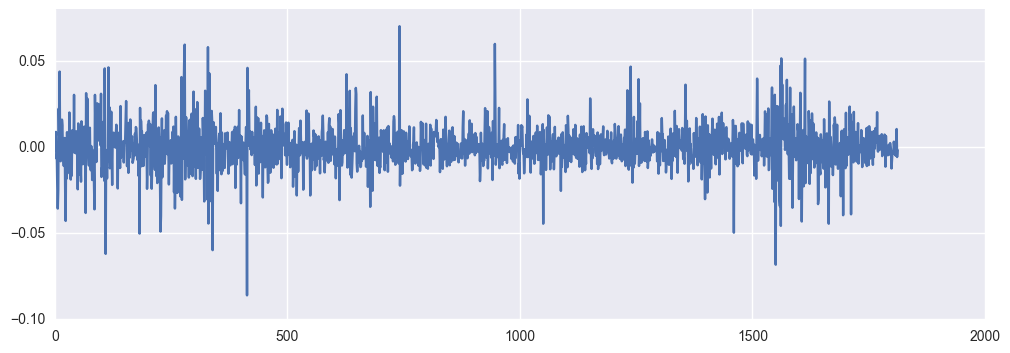

In [21]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(len(time_series)),time_series)

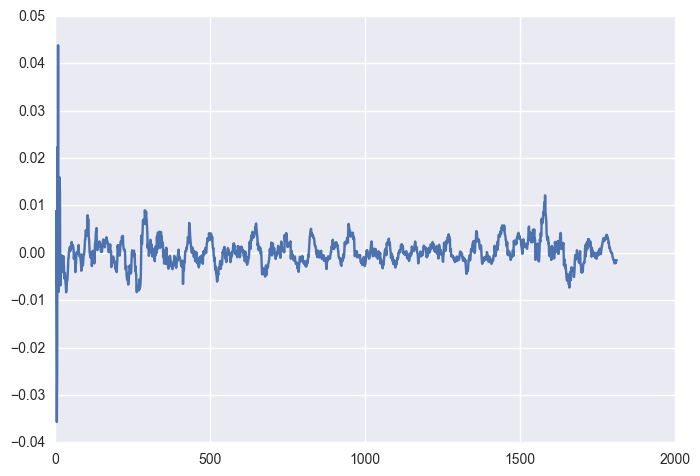

In [39]:
plt.plot(np.arange(len(mva(time_series,n=20))),mva(time_series,n=20))

In [32]:
Y_11= sigma[sigma.id == 11]["y"].reset_index(drop=True)

In [54]:
Y_11_transform=Y_11.rolling(window=20,min_periods=1).mean()

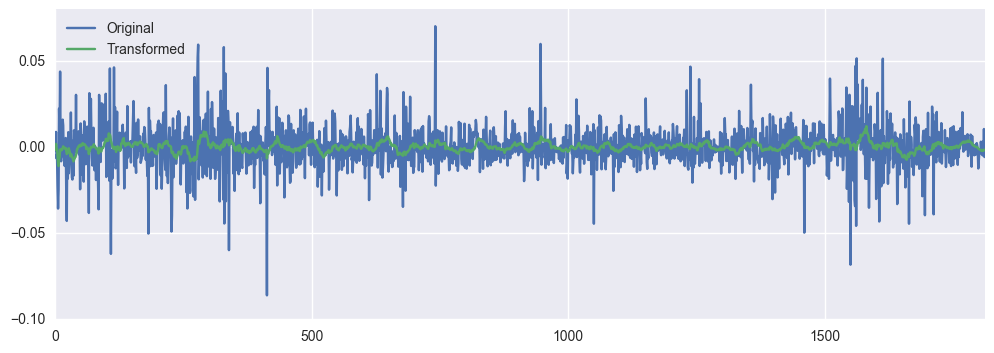

In [55]:
plt.figure(figsize=(12,4))
axis=plt.subplot(1,1,1)
compare = pd.DataFrame({'Original': Y_11, 'Transformed': Y_11_transform})
compare.plot(ax=axis)

In [4]:
variables_ts=["id","timestamp","technical_13","technical_20","technical_30","technical_11","technical_19","y"]
sigma_train_ts = sigma.loc[sigma["timestamp"].isin(sigma["timestamp"].unique()[:913]),variables_ts]

In [5]:
sigma_train_ts.head()

,id,timestamp,technical_13,technical_20,technical_30,technical_11,technical_19,y
0,10,0,0.001652,0.000000,0.0,-2.0,0.652981,-0.011753
1,11,0,0.004317,0.000000,0.0,-2.0,-0.399520,-0.001240
2,12,0,0.000000,0.006942,0.0,-2.0,-0.496284,-0.020940
3,25,0,0.000000,0.006766,0.0,-2.0,0.990627,-0.015959
4,26,0,0.000000,0.006236,0.0,-2.0,-0.086685,-0.007338


In [6]:
ts_grp=sigma_train_ts.groupby("id")

In [13]:
np.sort(sigma_train_ts.id.unique())

array([   0,    7,   10, ..., 2154, 2155, 2156])

In [14]:
iterate_ids=np.sort(sigma_train_ts.id.unique())
for Id in iterate_ids:
    sigma_train_ts.loc[sigma_train_ts.id==Id,"y"]=ts_grp.get_group(Id)["y"].rolling(window=20,min_periods=1).mean()
    if Id % 100 == 0:
        print("Id #{}".format(Id))

Id #0
Id #100
Id #300
Id #400
Id #500
Id #600
Id #700
Id #800
Id #1500
Id #2000
Id #2100


/home/reda/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


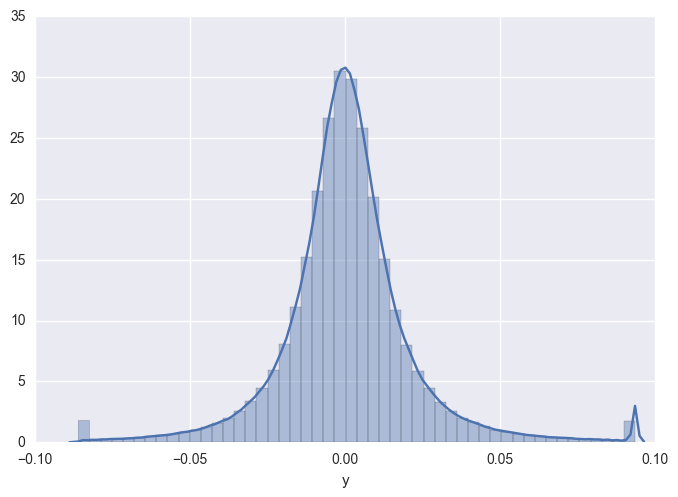

In [20]:
sns.distplot(sigma_train.y)

/home/reda/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


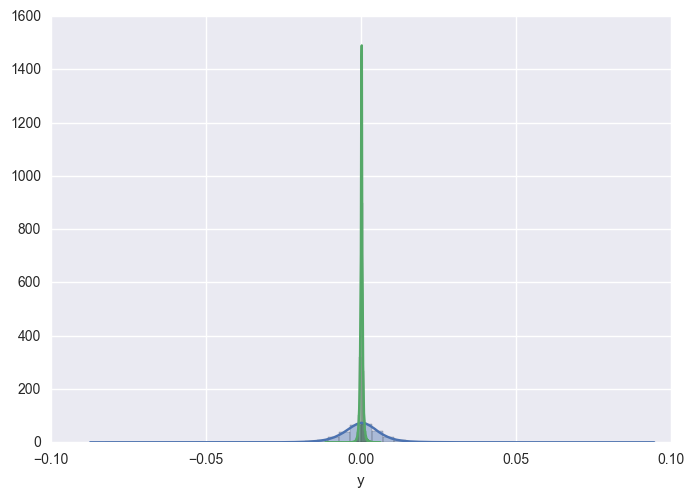

In [47]:
sns.distplot(sigma_train_ts.y)
sns.distplot(y_pred)

/home/reda/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


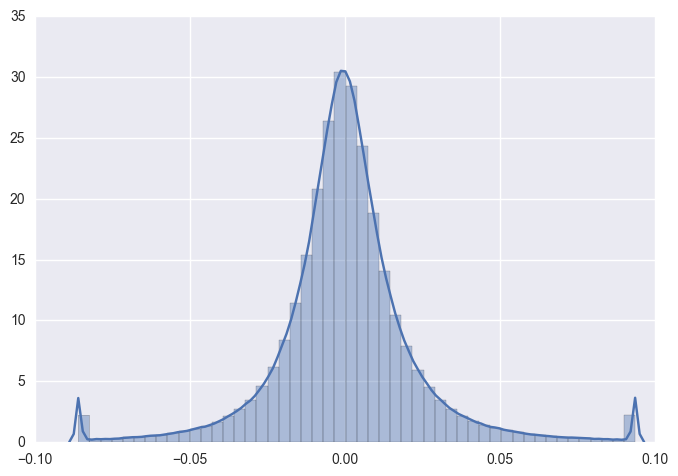

In [32]:
sns.distplot(y_test)

In [65]:
predictors=["technical_13","technical_20","technical_30","technical_11","technical_19"]
variables=["technical_13","technical_20","technical_30","technical_11","technical_19","y"]
sigma_train_ts_sub=sigma_train.loc[:,variables]
sigma_test=sigma_test.loc[:,variables]

In [66]:

X=sigma_train_ts_sub.loc[:,~sigma_train_ts_sub.columns.isin(["y"])].values
y=sigma_train_ts_sub.loc[:,"y"].values

X_test=sigma_test.loc[:,~sigma_test.columns.isin(["y"])].values
y_test=sigma_test.loc[:,"y"].values

In [67]:
lm_ts = LinearRegression(normalize=True).fit(X,y)

In [68]:
lm_ts.score(X_test,y_test)

0.00039105793310723058

In [26]:
y_pred=lm.predict(X_test)

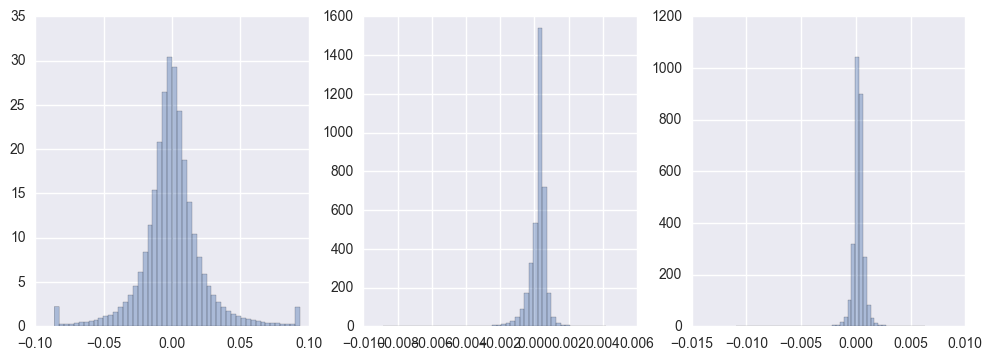

In [71]:
plt.figure(1)
f, axis = plt.subplots(1,3,figsize=(12,4))
sns.distplot(y_test,ax=axis[0],norm_hist=True,kde=False)
sns.distplot(lm.predict(X_test),ax=axis[1],norm_hist=True,kde=False)
sns.distplot(lm_ts.predict(X_test),ax=axis[2],norm_hist=True,kde=False)

### Study Correlations

In [54]:
sigma_11=sigma[sigma.id==11]

In [55]:
values=[]
columns=[c for c in sigma.columns if c not in ["id","timestamp","y"] ]
for col in columns:
    values.append(np.absolute(np.corrcoef(sigma_11[col].values, sigma_11.y.values)[0,1]))

In [92]:
pd.Series(columns)[values>=np.sort(values)[~np.isnan(np.sort(values))][::-1][4]].values

array(['technical_2', 'technical_14', 'technical_19', 'technical_21',
       'technical_30'], dtype=object)

In [43]:
np.corrcoef(sigma_11["technical_20"].values, sigma_11.y.values)[0,1]

-0.026459803077989775

In [10]:
grp_ids=sigma.groupby(["id"])

In [13]:
len(sigma.id.unique())

1424

In [38]:
grp_ids=sigma.groupby(["id"])
columns=[c for c in sigma.columns if c not in ["id","timestamp","y"] ]
ids_dict={}
i=0
for Id in sigma.id.unique():
    values=[]
    df=grp_ids.get_group(Id)
    for col in columns:
        values.append(np.absolute(np.corrcoef(df[col].values,df.y.values)[0,1]))
    if sum(~np.isnan(values))>=5:
        ids_dict[Id] = pd.Series(columns)[values>=np.sort(values)[~np.isnan(np.sort(values))][::-1][4]].values
    i+=1
    if i % 100 == 0:
        print(i)    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [39]:
pickle.dump( ids_dict, open( "ids_dict.p", "wb" ) )

In [177]:
ids_dict

NameError: name 'ids_dict' is not defined

##### Cluster ids based on each variables they correlate to the most

In [47]:
ids_corr = pd.DataFrame.from_dict(ids_dict,orient="index").ix[:,0:4]

In [48]:
ids_corr

,0,1,2,3,4
0,fundamental_15,fundamental_56,technical_6,technical_19,technical_43
6,technical_19,technical_25,technical_27,technical_35,technical_36
7,fundamental_7,technical_1,technical_13,technical_30,technical_44
10,fundamental_30,fundamental_36,fundamental_39,fundamental_46,fundamental_50
11,technical_2,technical_14,technical_19,technical_21,technical_30
12,fundamental_18,fundamental_41,fundamental_42,technical_19,technical_43
13,technical_17,technical_20,technical_24,technical_25,technical_41
14,fundamental_1,fundamental_25,fundamental_40,fundamental_52,technical_20
15,fundamental_7,fundamental_10,fundamental_18,fundamental_33,fundamental_36
16,fundamental_53,technical_0,technical_21,technical_22,technical_25


In [51]:
corr_binary=pd.DataFrame(index=ids_corr.index,columns=[c for c in sigma.columns if c not in ["id","timestamp","y"]],data=0)

In [54]:
ids_corr.ix[6].values

array(['technical_19', 'technical_25', 'technical_27', 'technical_35',
       'technical_36'], dtype=object)

In [55]:
corr_binary.ix[6,['technical_19', 'technical_25', 'technical_27', 'technical_35',
       'technical_36']]

technical_19    0
technical_25    0
technical_27    0
technical_35    0
technical_36    0
Name: 6, dtype: int64

In [ ]:
i=0
for index in corr_binary.index:
    cols=ids_corr.ix[index].values
    corr_binary.ix[index,cols]=[1]*5
    i+=1

In [61]:
corr_binary.head(2)

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [62]:
corr_binary.to_csv("./corr_binary.csv",sep=",")

In [4]:
corr_binary=pd.read_csv("/home/reda/Documents/kaggle/two_sigmas/git/two_sigmas/corr_binary.csv",index_col=0)

In [5]:
corr_binary.head(2)

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [8]:
Z = linkage(corr_binary.values, method='complete',metric="hamming")

In [10]:
c, coph_dists = cophenet(Z, pdist(corr_binary.values,'hamming'))

In [11]:
c

0.37517502528022584

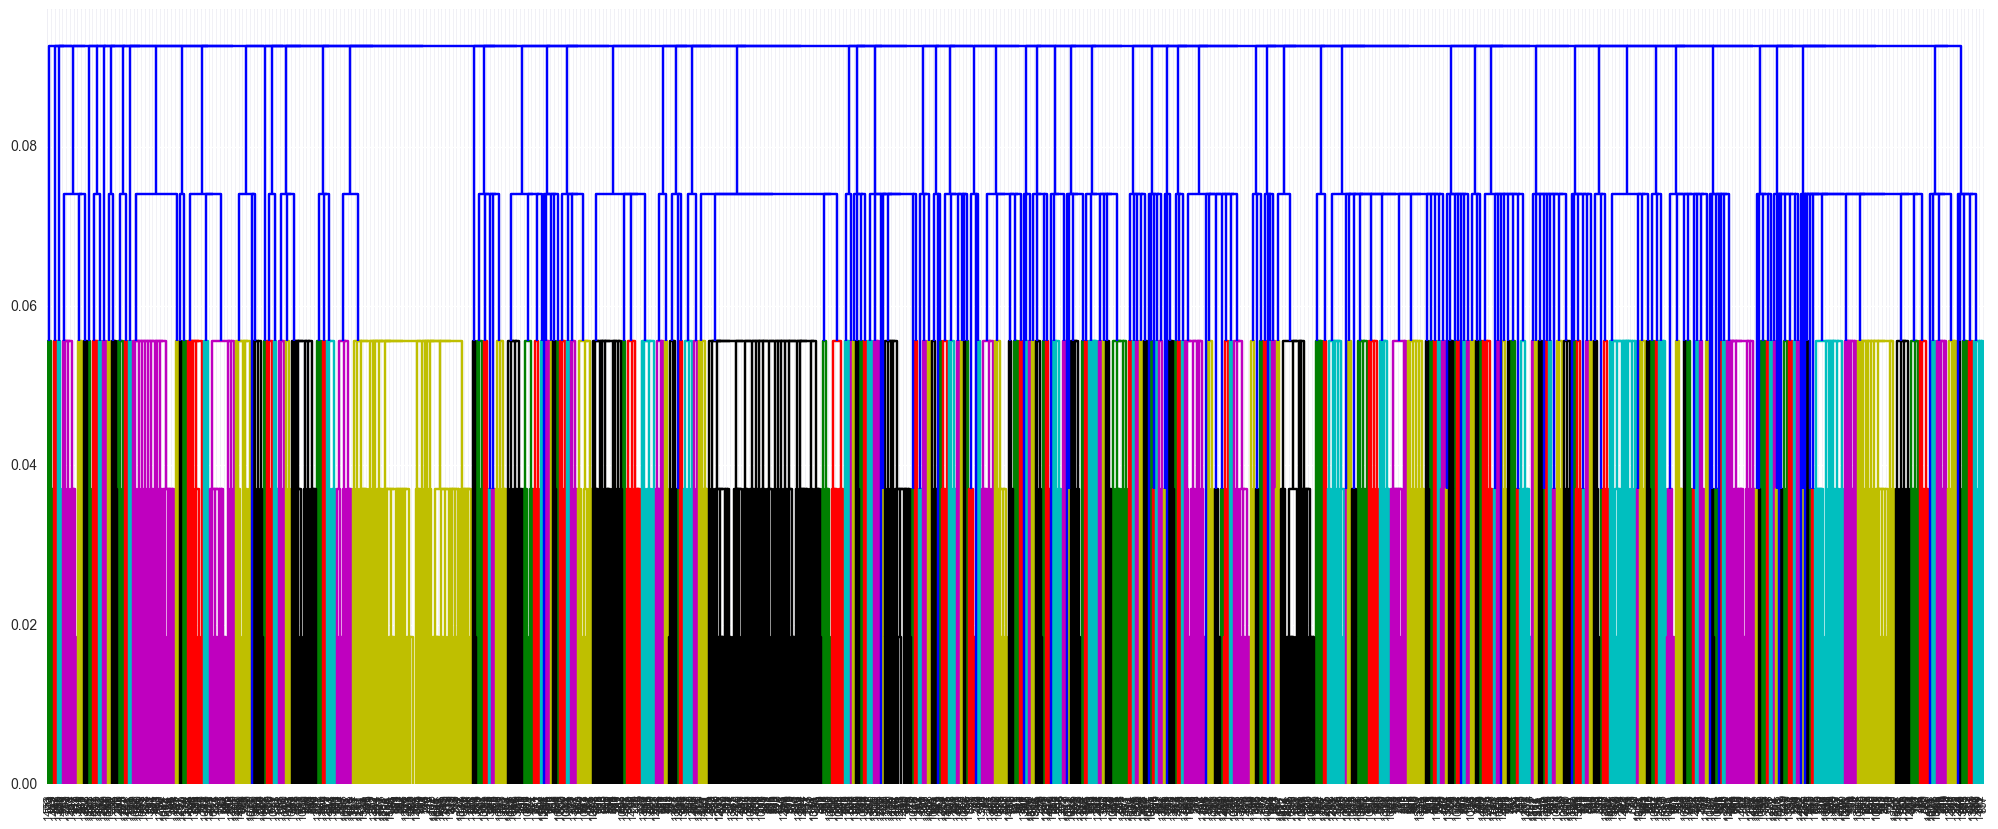

In [22]:
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

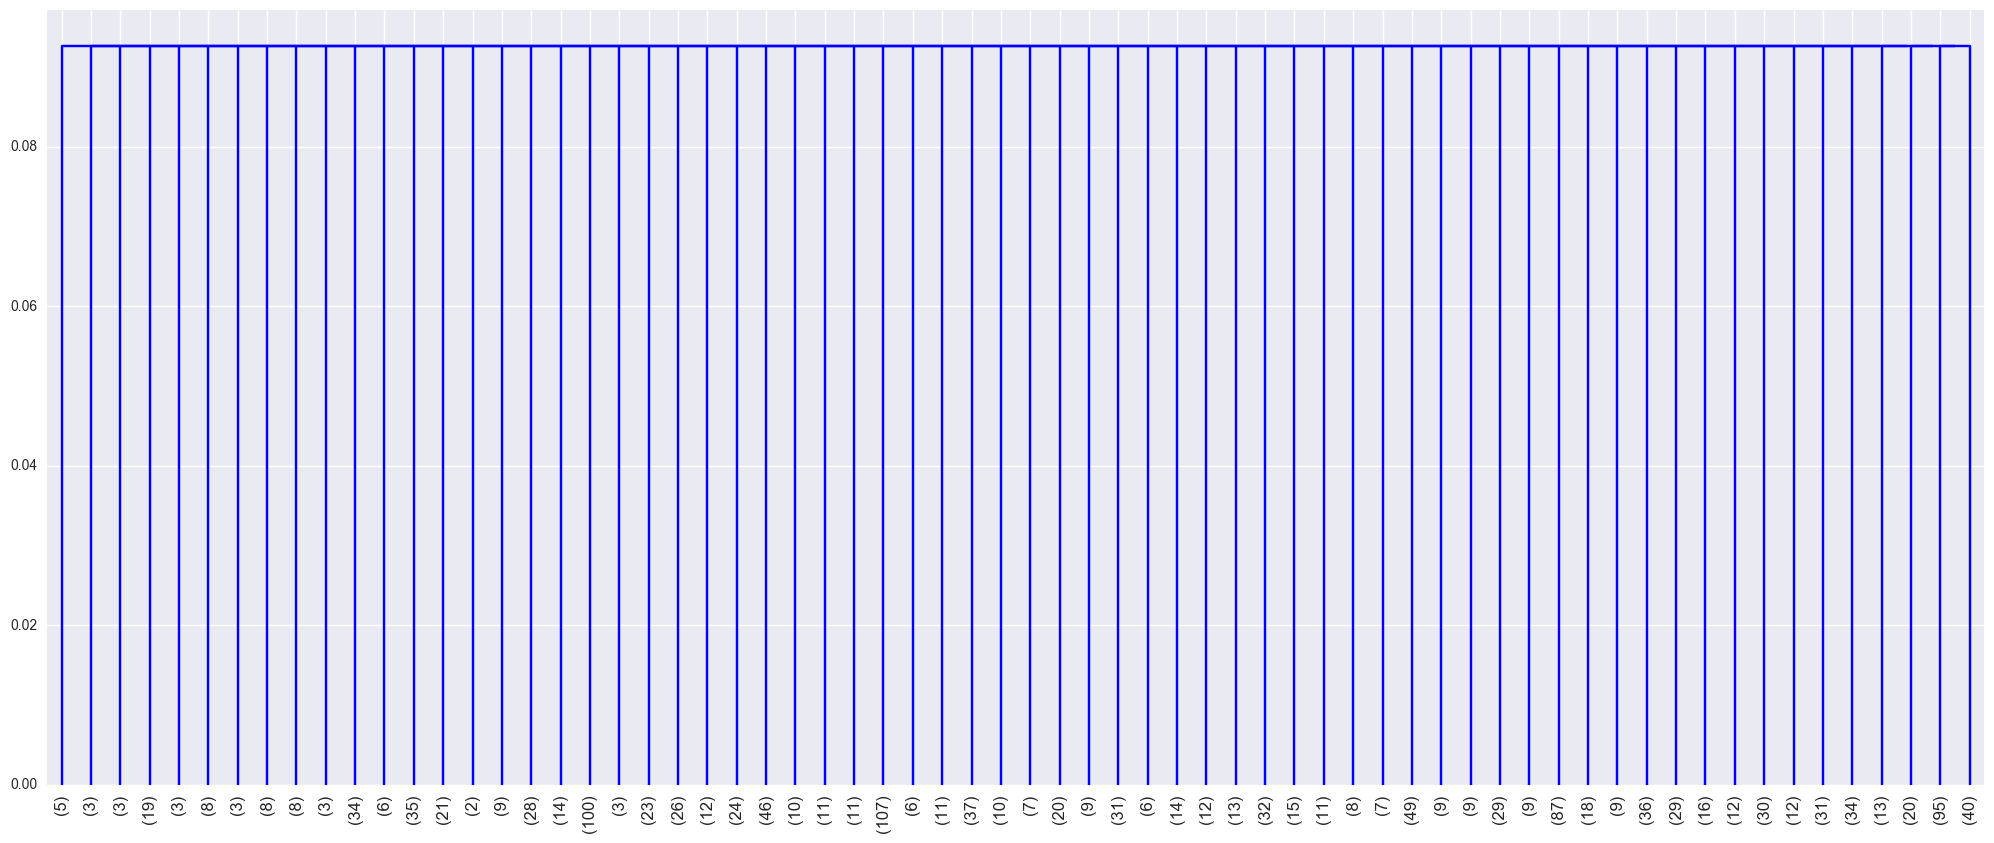

In [38]:
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=66,  # show only the last p merged clusters
    # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
cut_tree(Z,height=0.08).flatten()

In [46]:
corr_binary["cluster"]=cut_tree(Z,height=0.08).flatten()

In [49]:
corr_binary.tail(5)

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,cluster
2152,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,42
2154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,39
2155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,53
2156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,4


In [102]:
sigma[~sigma.id.isin(corr_binary.index)].id.unique()

array([1893,  435, 1229])

In [109]:
corr_binary[corr_binary.index==10]

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,cluster
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [126]:
clusters={}
for cluster in corr_binary.cluster.unique():
    clusters[cluster]=corr_binary[corr_binary.cluster==cluster].sum(axis=0).sort(ascending=False,inplace=False)[1:6].index.values

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


In [110]:
cluster_id=corr_binary.cluster.to_dict()

In [112]:
cluster_id

{0: 0,
 6: 1,
 7: 2,
 10: 3,
 11: 4,
 12: 5,
 13: 6,
 14: 7,
 15: 8,
 16: 9,
 17: 2,
 18: 10,
 19: 5,
 20: 11,
 22: 10,
 23: 12,
 24: 2,
 25: 13,
 26: 10,
 27: 14,
 30: 15,
 31: 16,
 32: 17,
 33: 18,
 38: 19,
 39: 0,
 40: 20,
 41: 21,
 43: 22,
 44: 4,
 46: 5,
 47: 18,
 48: 23,
 49: 10,
 52: 2,
 54: 24,
 55: 24,
 56: 7,
 58: 9,
 59: 13,
 60: 25,
 62: 26,
 63: 16,
 64: 2,
 65: 27,
 66: 5,
 68: 2,
 69: 23,
 70: 12,
 72: 28,
 76: 29,
 77: 7,
 79: 17,
 80: 13,
 81: 30,
 82: 31,
 83: 15,
 85: 11,
 87: 14,
 88: 30,
 90: 5,
 91: 29,
 93: 26,
 95: 11,
 97: 32,
 98: 11,
 99: 20,
 100: 12,
 101: 33,
 102: 16,
 103: 34,
 104: 16,
 105: 26,
 106: 2,
 108: 29,
 111: 4,
 112: 11,
 113: 10,
 115: 32,
 118: 10,
 119: 35,
 121: 16,
 122: 5,
 124: 21,
 126: 29,
 127: 7,
 128: 2,
 129: 12,
 130: 11,
 131: 2,
 132: 36,
 133: 22,
 134: 11,
 137: 13,
 140: 12,
 141: 13,
 142: 37,
 149: 38,
 150: 21,
 151: 8,
 152: 29,
 154: 39,
 156: 36,
 158: 4,
 159: 20,
 160: 13,
 161: 29,
 163: 2,
 166: 13,
 169: 22,
 17

In [113]:
cluster_id[435]=0
cluster_id[1893]=0
cluster_id[1229]=0

###### training on clustered Ids

In [114]:
sigma_train["cluster"]=sigma_train.id.map(lambda x: cluster_id[x])

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [122]:
clusters[10]

technical_30    104
technical_20    100
technical_5      17
technical_21     16
technical_13     13
dtype: int64

In [174]:
linear={}
for cluster in sigma_train.cluster.unique():
    df=sigma_train[sigma_train.cluster==cluster]
    if len(sigma_test[sigma_test.cluster==cluster]) > 10000:
        linear[cluster]=LinearRegression().fit(df.loc[:,clusters[cluster]].values,df.loc[:,"y"].values)
    else:
        linear[cluster]=LinearRegression().fit(sigma_train.loc[:,"technical_20"].values.reshape(-1,1),sigma_train.loc[:,"y"].values)

In [131]:
sigma_test["cluster"]=sigma_test.id.map(lambda x: cluster_id[x])

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [132]:
sigma_test["y_pred"]=np.NaN

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [140]:
linear[11].predict(sigma_test.loc[sigma_test.cluster==11,clusters[11]].values)

array([ -6.56586693e-05,  -1.50737221e-04,  -1.70399329e-05, ...,
         1.54621588e-04,  -1.20324268e-04,  -6.27078151e-05])

In [175]:
for cluster in sigma_test.cluster.unique():
    if len(sigma_test[sigma_test.cluster==cluster]) > 10000:
        sigma_test.loc[sigma_test.cluster==cluster,"y_pred"]=linear[cluster].predict(sigma_test.loc[sigma_test.cluster==cluster,clusters[cluster]].values)
    else:
        sigma_test.loc[sigma_test.cluster==cluster,"y_pred"]=linear[cluster].predict(sigma_test.loc[:,"technical_20"].values.reshape(-1,1))

/home/reda/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [150]:
sigma_train.y.mean()

0.0002635416458360851

In [176]:
r2_score(sigma_test.y.values,sigma_test.y_pred.values)

-0.0021418966010497975

In [154]:
scores={}
for cluster in sigma_test.cluster.unique():
    scores[cluster]=linear[cluster].score(sigma_test.loc[sigma_test.cluster==cluster,clusters[cluster]].values,sigma_test.loc[sigma_test.cluster==cluster,"y"])

In [155]:
for cluster in sigma_test.cluster.unique():
    print(len(sigma_test[sigma_test.cluster==cluster]))

13628
60251
24070
25778
8135
17597
11175
65564
79116
56633
25162
20720
3679
20458
34438
23928
6074
8559
4462
3768
16952
22885
14535
4254
10394
7025
8771
8868
21334
16399
13436
14830
17599
14554
14978
14495
14527
4683
7289
4109
8460
7372
6620
7209
1761
6183
4429
5402
5553
6495
14779
4521
2296
4509
4978
4238
4507
1285
8188
4290
5574
3829
1559
2018
1556
914
4048


In [148]:
sigma_test[sigma_test.cluster==66]

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y,cluster,y_pred
813757,1570,913,0.027662,0.014510,0.439079,0.240475,0.191891,0.255667,-0.007395,-0.446730,-0.040183,0.033375,-0.010537,-0.214177,-0.144617,-0.208962,-0.063175,-0.552317,0.000348,0.306336,0.278500,-0.101094,-0.376268,0.115224,-0.203526,0.351111,-0.007500,0.450182,-0.315039,-0.102513,-0.297233,0.053609,-0.005522,0.713181,-0.024560,0.346774,0.021085,-0.022934,-0.003941,0.112682,12.064609,-0.251860,-0.201070,0.425497,-0.007763,0.468580,-0.020281,0.064372,0.120365,0.066671,0.492229,0.095502,1.216125,0.015905,-0.192656,1.132446,0.421041,-6.744577,-0.013581,-0.258668,0.463784,-0.433536,-0.323811,-0.004867,-0.030392,0.066739,-0.127123,-0.000419,0.083146,-0.012422,0.000000e+00,-0.000483,-1.881398,-0.000330,0.000034,-1.881398e+00,-0.101955,0.0,0.000000e+00,-1.881398,0.000000,0.000000,0.000000e+00,0.000000e+00,-2.000000,0.000000e+00,0.427117,0.001317,-0.425113,0.5,0.000190,0.000376,0.222861,0.000239,0.000000e+00,0.000000,-0.000382,0.000000e+00,-0.127545,0.0,0.584983,0.903392,0.000000e+00,0.000000e+00,0.000000e+00,-0.020363,0.000098,0.000000e+00,0.000000e+00,0.000011,-0.003674,66,0.006155
814724,1570,914,0.027538,0.014510,0.439079,0.240217,0.191344,0.255760,-0.007395,-0.446784,-0.040183,0.033375,-0.010537,-0.214065,-0.144617,-0.208891,-0.063175,-0.552397,0.000348,0.306336,0.278500,-0.101018,-0.376268,0.115224,-0.203341,0.351111,-0.007500,0.450182,-0.315039,-0.102513,-0.297575,0.053609,-0.005522,0.713181,-0.024560,0.346774,0.021131,-0.022934,-0.003941,0.112682,12.064609,-0.251860,-0.201017,0.425497,-0.007763,0.468580,-0.020281,0.064031,0.119878,0.066671,0.492229,0.095513,1.216125,0.015905,-0.192586,1.132446,0.421041,-6.744577,-0.013581,-0.258375,0.463784,-0.433510,-0.323795,-0.004867,-0.030392,0.066739,-0.127075,-0.000419,0.080097,-0.012422,0.000000e+00,-0.000483,-1.910191,-0.000330,0.000034,-1.910191e+00,-0.102138,0.0,0.000000e+00,-1.910191,0.000000,0.000152,0.000000e+00,0.000000e+00,-2.000000,0.000000e+00,0.430263,0.000000,-0.428990,0.5,0.000190,0.000376,0.210881,0.000239,0.000000e+00,0.000000,-0.000382,0.000000e+00,-0.203142,0.0,0.582284,0.903702,0.000000e+00,0.000000e+00,0.000000e+00,-0.020711,0.000098,0.000000e+00,0.000000e+00,0.000011,-0.014525,66,0.006337
815691,1570,915,0.028820,0.014780,0.427779,0.247279,0.194068,0.250537,-0.007395,-0.445077,-0.040183,0.033375,-0.010537,-0.212192,-0.144361,-0.207955,-0.063175,-0.550029,0.000348,0.305952,0.276426,-0.099717,-0.374184,0.122089,-0.199452,0.351111,-0.007500,0.449285,-0.315098,-0.107020,

In [156]:
scores

{0: 0.0011654502820341861,
 1: 0.0024737840501826147,
 2: -0.00010676964274103362,
 3: -0.044726238955306918,
 4: 0.0025253496446872026,
 5: -0.0052069956565996556,
 6: -0.0015938240280444218,
 7: 0.0018806076250997839,
 8: -0.06149654859759246,
 9: -0.00443784310337203,
 10: 0.0032873324131819097,
 11: -0.001481068724647816,
 12: -0.0027938648801286714,
 13: -0.0013589725142033604,
 14: 0.00075501738051442224,
 15: 0.0013913308425109738,
 16: -0.00028143580665718204,
 17: -1.0153607596405139,
 18: 0.0014499008184084559,
 19: 0.0038344394604405974,
 20: 8.3932501874106613e-05,
 21: 0.00044058536620783517,
 22: 0.0039506541287983588,
 23: -7.1977160551739416e-06,
 24: -1.2678107023952481,
 25: -0.0034793722505317426,
 26: -0.0049519138027651621,
 27: 0.0045216084594644768,
 28: -0.037023040579229116,
 29: 0.002243983634492186,
 30: 0.00025333468971078243,
 31: -0.0031932511376298045,
 32: -0.00084234397438431863,
 33: -0.035710263060744873,
 34: 0.00016301787073791374,
 35: -0.000470384

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=50,min_periods=1).mean()
  app.launch_new_instance()


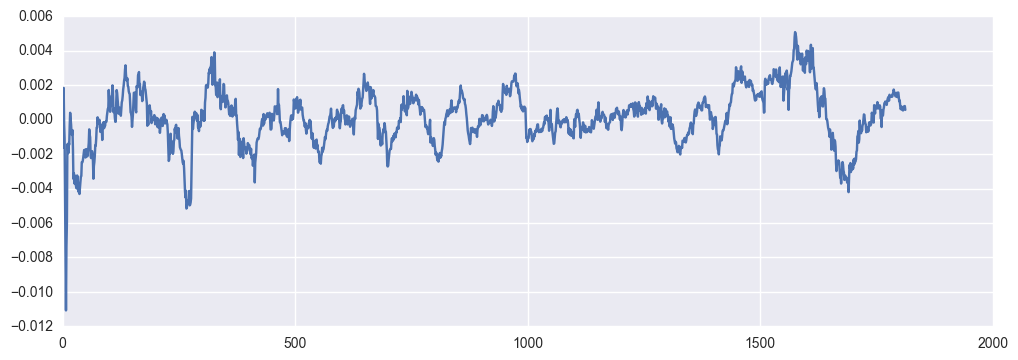

In [30]:
plt.figure(figsize=(12,4))
#plt.plot(sigma[sigma.id==11].timestamp,sigma[sigma.id==11].y)
plt.plot(sigma[sigma.id==11].timestamp,pd.rolling_mean(sigma[sigma.id==11].y,50,min_periods=1))

In [17]:
sigma[sigma.id==11].y.values

array([-0.00124014, -0.00202434,  0.00878802, ...,  0.01046138,
       -0.00577943, -0.0017718 ], dtype=float32)

In [18]:
pd.rolling_mean(sigma[sigma.id==11].y,10,min_periods=1).values

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10,min_periods=1).mean()
  if __name__ == '__main__':


array([-0.00124014, -0.00163224,  0.00184118, ..., -0.00019339,
       -0.00049354, -0.00030793])

In [7]:
def hiarchical_clust_plus(corr_binary,HIERCHICAL_METHOD,HIERCHICAL_NB_CLUSTERS):
    #Hiearchical clustering
    Z = linkage(corr_binary.values, method=HIERCHICAL_METHOD,metric="hamming")
    c, coph_dists = cophenet(Z, pdist(corr_binary.values,'hamming'))
    
    #construct dict hloding ids(values) belonging to each cluster(key)
    corr_binary["cluster"]=cut_tree(Z,n_clusters=HIERCHICAL_NB_CLUSTERS).flatten()
    cluster_id=corr_binary.cluster.to_dict()
    cols=sigma[~sigma.id.isin(corr_binary.index)].id.unique()
    for col in cols:
        cluster_id[col]=0

    #construct dict holding NB_FEATURES features(values) for each cluster(key)    
    clusters={}
    for cluster in corr_binary.cluster.unique():
        clusters[cluster]=corr_binary[corr_binary.cluster==cluster].sum(axis=0).sort(ascending=False,inplace=False)[1:NB_FEATURES+1].index.values
   
    #sigma_train["cluster"]=sigma_train.id.map(lambda x: cluster_id[x])
    #sigma_test["cluster"]=sigma_test.id.map(lambda x: cluster_id[x])
    
    return clusters, cluster_id

In [9]:
exclude_preds=[]

In [68]:
def construct_df_plus(NB_FEATURES):
    #construct the dictionnary containing top fatures for each id
    grp_ids=sigma.groupby(["id"])
    columns=[c for c in sigma.columns if c not in (["id","timestamp","y"]+exclude_preds) ]
    ids_dict={}
    for Id in sigma.id.unique():
        values=[]
        df=grp_ids.get_group(Id)
        for col in columns:
            values.append(np.absolute(np.corrcoef(df[col].values,pd.rolling_mean(df.y,10,min_periods=1).values)[0,1]))
        if sum(~np.isnan(values))>=5:
            ids_dict[Id] = pd.Series(columns)[values>=np.sort(values)[~np.isnan(np.sort(values))][::-1][NB_FEATURES-1]].values
    # construct dataframe from above dict
    ids_corr = pd.DataFrame.from_dict(ids_dict,orient="index").ix[:,0:(NB_FEATURES-1)]
    # construct dataframe with binary values
    corr_binary=pd.DataFrame(index=ids_corr.index,columns=[c for c in sigma.columns if c not in ["id","timestamp","y"]],data=0)
    for index in corr_binary.index:
        cols=ids_corr.ix[index].values
        corr_binary.ix[index,cols]=[1]*NB_FEATURES
    return corr_binary

In [69]:
cl,cl_ids=hiarchical_clust_plus(construct_df_plus(NB_FEATURES),HIERCHICAL_METHOD,HIERCHICAL_NB_CLUSTERS)

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10,min_periods=1).mean()
/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [70]:
pd.DataFrame.from_dict(cl_ids,orient="index")[0].value_counts()

0     1295
4       33
7       12
8       12
6       11
11      10
1        7
9        7
13       5
2        5
10       4
15       4
16       4
14       3
5        3
3        3
12       2
18       2
17       1
19       1
Name: 0, dtype: int64

In [172]:
pd.DataFrame.from_dict(cl_ids,orient="index")[0].value_counts()

2     328
0     153
6     137
3     112
1     110
8      78
7      77
9      70
5      58
13     49
4      44
11     40
14     37
16     30
12     28
10     26
15     23
17     13
18      6
19      5
Name: 0, dtype: int64

In [207]:
df=pd.DataFrame.from_dict(cl_ids,orient="index")
df[df[0]==19][0].index.values

array([ 682,  841, 1336, 1473, 1599])

In [61]:
cl

{0: array(['technical_11', 'technical_30', 'fundamental_46'], dtype=object),
 1: array(['technical_10', 'fundamental_36', 'fundamental_48'], dtype=object),
 2: array(['fundamental_17', 'fundamental_50', 'fundamental_59'], dtype=object),
 3: array(['fundamental_54', 'derived_2', 'derived_1'], dtype=object),
 4: array(['fundamental_33', 'fundamental_42', 'fundamental_62'], dtype=object),
 5: array(['technical_27', 'technical_19', 'technical_43'], dtype=object),
 6: array(['technical_30', 'fundamental_20', 'fundamental_45'], dtype=object),
 7: array(['technical_19', 'technical_21', 'technical_35'], dtype=object),
 8: array(['fundamental_24', 'fundamental_8', 'fundamental_19'], dtype=object),
 9: array(['fundamental_21', 'technical_7', 'technical_40'], dtype=object),
 10: array(['technical_20', 'technical_3', 'fundamental_35'], dtype=object),
 11: array(['derived_2', 'fundamental_30', 'fundamental_34'], dtype=object),
 12: array(['fundamental_2', 'fundamental_53', 'fundamental_11'], dtype=

In [209]:
np.arange(1,19,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [53]:
cl[5]

array(['technical_27', 'technical_19', 'technical_43'], dtype=object)

In [54]:
cl[7]

array(['technical_19', 'technical_21', 'technical_35'], dtype=object)

#### Automate the process

In [49]:
# The number of top features that correlate the most with y
NB_FEATURES=3
HIERCHICAL_METHOD="weighted"
HIERCHICAL_NB_CLUSTERS=20
MIN_NB_OF_ROWS_PER_CLUSTER = 5000

In [63]:
def construct_df(NB_FEATURES):
    #construct the dictionnary containing top fatures for each id
    grp_ids=sigma_train.groupby(["id"])
    columns=[c for c in sigma_train.columns if c not in ["id","timestamp","y"] ]
    ids_dict={}
    for Id in sigma_train.id.unique():
        values=[]
        df=grp_ids.get_group(Id)
        for col in columns:
            values.append(np.absolute(np.corrcoef(df[col].values,pd.rolling_mean(df.y,10,min_periods=1).values)[0,1]))
        if sum(~np.isnan(values))>=5:
            ids_dict[Id] = pd.Series(columns)[values>=np.sort(values)[~np.isnan(np.sort(values))][::-1][NB_FEATURES-1]].values
    # construct dataframe from above dict
    ids_corr = pd.DataFrame.from_dict(ids_dict,orient="index").ix[:,0:(NB_FEATURES-1)]
    # construct dataframe with binary values
    corr_binary=pd.DataFrame(index=ids_corr.index,columns=[c for c in sigma_train.columns if c not in ["id","timestamp","y"]],data=0)
    for index in corr_binary.index:
        cols=ids_corr.ix[index].values
        corr_binary.ix[index,cols]=[1]*NB_FEATURES
    return corr_binary

In [58]:
def hiarchical_clust(corr_binary,HIERCHICAL_METHOD,HIERCHICAL_NB_CLUSTERS):
    #Hiearchical clustering
    Z = linkage(corr_binary.values, method=HIERCHICAL_METHOD,metric="hamming")
    c, coph_dists = cophenet(Z, pdist(corr_binary.values,'hamming'))
    
    #construct dict hloding ids(values) belonging to each cluster(key)
    corr_binary["cluster"]=cut_tree(Z,n_clusters=HIERCHICAL_NB_CLUSTERS).flatten()
    cluster_id=corr_binary.cluster.to_dict()
    cols=sigma[~sigma.id.isin(corr_binary.index)].id.unique()
    for col in cols:
        cluster_id[col]=0

    #construct dict holding NB_FEATURES features(values) for each cluster(key)    
    clusters={}
    for cluster in corr_binary.cluster.unique():
        clusters[cluster]=corr_binary[corr_binary.cluster==cluster].sum(axis=0).sort(ascending=False,inplace=False)[1:NB_FEATURES+1].index.values
   
    sigma_train["cluster"]=sigma_train.id.map(lambda x: cluster_id[x])
    sigma_test["cluster"]=sigma_test.id.map(lambda x: cluster_id[x])
    
    return clusters

In [57]:
def fit_pred(clusters,MIN_NB_OF_ROWS_PER_CLUSTER):    
    #Fitting a linear regression model
    linear={}
    for cluster in sigma_train.cluster.unique():
        df=sigma_train[sigma_train.cluster==cluster]
        if len(sigma_test[sigma_test.cluster==cluster]) > MIN_NB_OF_ROWS_PER_CLUSTER:
            linear[cluster]=LinearRegression().fit(df.loc[:,clusters[cluster]].values,df.loc[:,"y"].values)
        else:
            linear[cluster]=LinearRegression().fit(sigma_train.loc[:,"technical_20"].values.reshape(-1,1),sigma_train.loc[:,"y"].values)
            
    #Predicting
    sigma_test["y_pred"]=np.NaN
    for cluster in sigma_test.cluster.unique():
        if len(sigma_test[sigma_test.cluster==cluster]) > MIN_NB_OF_ROWS_PER_CLUSTER:
            sigma_test.loc[sigma_test.cluster==cluster,"y_pred"]=linear[cluster].predict(sigma_test.loc[sigma_test.cluster==cluster,clusters[cluster]].values)
        else:
            sigma_test.loc[sigma_test.cluster==cluster,"y_pred"]=linear[cluster].predict(sigma_test.loc[:,"technical_20"].values.reshape(-1,1))
    
    #scoring
    return r2_score(sigma_test.y.values,sigma_test.y_pred.values)

###### Tests

In [64]:
nb_features=[3]
score_nb_features={}
for NB_FEATURES in nb_features:
    score_nb_features[NB_FEATURES]=fit_pred( hiarchical_clust(construct_df(NB_FEATURES),HIERCHICAL_METHOD,HIERCHICAL_NB_CLUSTERS),  MIN_NB_OF_ROWS_PER_CLUSTER)
    print(NB_FEATURES)

/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10,min_periods=1).mean()
/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

3


In [19]:
for key, value in score_nb_features.items():
    print("Score with %f features: %f"%(key,value))

Score with 2.000000 features: -0.000323
Score with 3.000000 features: -0.002583
Score with 20.000000 features: -4160683374627576610816.000000
Score with 10.000000 features: -0.344431


In [21]:
for key, value in score_nb_features.items():
    print("Score with %f features: %f"%(key,value))

Score with 1.000000 features: -0.000087


In [24]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters: %f"%(key,HIERCHICAL_NB_CLUSTERS,value))

Score with 1 features and 20 clusters: 0.000259
Score with 2 features and 20 clusters: 0.000246


In [27]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters: %f"%(key,HIERCHICAL_NB_CLUSTERS,value))

Score with 1 features and 10 clusters: 0.000277
Score with 2 features and 10 clusters: 0.000251
Score with 3 features and 10 clusters: 0.000229
Score with 4 features and 10 clusters: 0.000221


In [31]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters and %s method: %f"%(key,HIERCHICAL_NB_CLUSTERS,HIERCHICAL_METHOD,value))

Score with 1 features and 20 clusters and single method: 0.000182
Score with 2 features and 20 clusters and single method: 0.000262
Score with 3 features and 20 clusters and single method: 0.000252
Score with 4 features and 20 clusters and single method: 0.000274


In [33]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters and %s method: %f"%(key,HIERCHICAL_NB_CLUSTERS,HIERCHICAL_METHOD,value))

Score with 5 features and 20 clusters and single method: 0.000272
Score with 6 features and 20 clusters and single method: -0.001323
Score with 7 features and 20 clusters and single method: -0.001031
Score with 8 features and 20 clusters and single method: -0.001959
Score with 9 features and 20 clusters and single method: -0.001337
Score with 10 features and 20 clusters and single method: -0.001375


In [103]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters and %s method: %f"%(key,HIERCHICAL_NB_CLUSTERS,HIERCHICAL_METHOD,value))

Score with 4 features and 20 clusters and average method: -0.346272


In [131]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters and %s method: %f"%(key,HIERCHICAL_NB_CLUSTERS,HIERCHICAL_METHOD,value))

Score with 4 features and 20 clusters and weighted method: -0.040577


In [65]:
for key, value in score_nb_features.items():
    print("Score with %d features and %d clusters and %s method and with ma: %f"%(key,HIERCHICAL_NB_CLUSTERS,HIERCHICAL_METHOD,value))

Score with 3 features and 20 clusters and weighted method and with ma: -0.000061
